In [1]:
# ! git clone https://github.com/eva-6-3/cnn_regularizations
# ! pip install torchsummary
# ! pip3 install ipywidgets --user
# ! pip install seaborn

In [2]:
import sys
sys.path.append('../utils/')

In [3]:
from data import MNIST_dataset
from misc import (
    show_random_images,
    get_device,
    set_seed,
    is_cuda,
    show_model_summary,
)
from model import Net
from training import train
from testing import test

In [4]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.optim as optim
import numpy as np

### Device

In [5]:
set_seed()
cuda = is_cuda()
device = get_device()

[INFO] seed set 1
[INFO] Cuda Avaliable :  True
[INFO] device :  cuda


## Data Loader

In [6]:
train_loader = MNIST_dataset(
    train=True, cuda=cuda
).get_loader()
test_loader = MNIST_dataset(
    train=False, cuda=cuda
).get_loader()


        [INFO] train dataset of size 60000 loaded...
        

        [INFO] test dataset of size 10000 loaded...
        


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


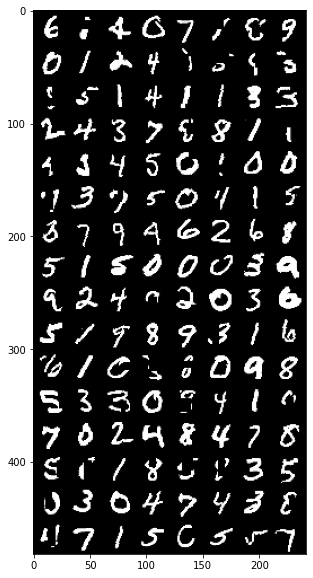

In [7]:
show_random_images(train_loader)

## Load Model

In [8]:
from tqdm.notebook import tqdm
import pandas as pd

In [9]:
"""
Network with Group Normalization + L1
Network with Layer Normalization + L2
Network with L1 + L2 + BN
"""
experiments= [
    {'BN': False, 'GN': True, 'LN': False, 'L1': True, 'L2': False},
    {'BN': False, 'GN': False, 'LN': True, 'L1': False, 'L2': True},
    {'BN': True, 'GN': False, 'LN': False, 'L1': True, 'L2': True},
]
EPOCHS = 25
results = {}
models = {}
for exp in experiments:
    exp_name = ""
    for param, val in exp.items():
        if val:
            exp_name += f"{param}__"
    exp_name = exp_name.strip('__')
    print("Experiment : ", exp_name)
    results[exp_name] = {
        'train_loss': [],
        'train_acc': [],
        'test_loss': [],
        'test_acc': [],
        'epoch': [],
    }

    net = Net(
        dropout_value=0.05, BN=exp['BN'], GN=exp['GN'], LN=exp['LN']
    ).to(device)
    show_model_summary(net)

    weight_decay = 1e-5 if exp['L2'] else 0
    optimizer = optim.SGD(
        net.parameters(), 
        lr=0.020, momentum=0.9, 
        weight_decay=weight_decay
    )
    lr_scheduler = ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, 
        patience=2, min_lr=0.001, verbose=True
    )

    for epoch in tqdm(range(1, EPOCHS + 1)):
        print(f"[EPOCH {epoch} / {EPOCHS}] -- ")
        train_loss_batch, train_acc_batch = train(
            net, device, 
            train_loader, 
            optimizer, 
            lr_scheduler,
            L1=exp['L1']
        )
        train_acc = np.mean(train_acc_batch)
        train_loss = np.mean(train_loss_batch)

        test_loss, test_acc = test(
            net, device, 
            test_loader,
            lr_scheduler
        )
        for metric in ['train_loss', 'train_acc', 'test_loss', 'test_acc', 'epoch']:
            results[exp_name][metric].append(eval(metric))
    
    models[exp_name] = net

Experiment :  GN__L1
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 26, 26]              54
              ReLU-2            [-1, 6, 26, 26]               0
           Dropout-3            [-1, 6, 26, 26]               0
         GroupNorm-4            [-1, 6, 26, 26]              12
            Conv2d-5           [-1, 12, 24, 24]             648
              ReLU-6           [-1, 12, 24, 24]               0
           Dropout-7           [-1, 12, 24, 24]               0
         GroupNorm-8           [-1, 12, 24, 24]              24
            Conv2d-9            [-1, 7, 24, 24]              84
        MaxPool2d-10            [-1, 7, 12, 12]               0
           Conv2d-11           [-1, 16, 10, 10]           1,008
             ReLU-12           [-1, 16, 10, 10]               0
          Dropout-13           [-1, 16, 10, 10]               0
        GroupNorm-

  0%|          | 0/469 [00:00<?, ?it/s]

[EPOCH 1 / 25] -- 


Loss=2.0301296710968018 Batch_id=468 Accuracy=68.17: 100%|██████████| 469/469 [00:07<00:00, 61.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.4932, Accuracy: 8437/10000 (84.37%)

[EPOCH 2 / 25] -- 


Loss=1.5743545293807983 Batch_id=468 Accuracy=77.27: 100%|██████████| 469/469 [00:07<00:00, 62.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.4503, Accuracy: 8647/10000 (86.47%)

[EPOCH 3 / 25] -- 


Loss=1.6370184421539307 Batch_id=468 Accuracy=78.44: 100%|██████████| 469/469 [00:07<00:00, 62.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.5423, Accuracy: 8269/10000 (82.69%)

[EPOCH 4 / 25] -- 


Loss=1.6211122274398804 Batch_id=468 Accuracy=78.25: 100%|██████████| 469/469 [00:07<00:00, 63.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.4397, Accuracy: 8745/10000 (87.45%)

[EPOCH 5 / 25] -- 


Loss=1.580306053161621 Batch_id=468 Accuracy=78.94: 100%|██████████| 469/469 [00:07<00:00, 63.66it/s] 
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.4598, Accuracy: 8626/10000 (86.26%)

[EPOCH 6 / 25] -- 


Loss=1.7035858631134033 Batch_id=468 Accuracy=78.85: 100%|██████████| 469/469 [00:07<00:00, 63.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.4161, Accuracy: 8898/10000 (88.98%)

[EPOCH 7 / 25] -- 


Loss=1.6768159866333008 Batch_id=468 Accuracy=78.96: 100%|██████████| 469/469 [00:07<00:00, 62.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.4127, Accuracy: 8852/10000 (88.52%)

[EPOCH 8 / 25] -- 


Loss=1.7346947193145752 Batch_id=468 Accuracy=79.56: 100%|██████████| 469/469 [00:07<00:00, 62.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.4848, Accuracy: 8625/10000 (86.25%)

[EPOCH 9 / 25] -- 


Loss=1.6622796058654785 Batch_id=468 Accuracy=79.61: 100%|██████████| 469/469 [00:07<00:00, 62.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.4008, Accuracy: 8928/10000 (89.28%)

[EPOCH 10 / 25] -- 


Loss=1.6888408660888672 Batch_id=468 Accuracy=79.56: 100%|██████████| 469/469 [00:07<00:00, 63.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.4140, Accuracy: 8835/10000 (88.35%)

[EPOCH 11 / 25] -- 


Loss=1.474182367324829 Batch_id=468 Accuracy=79.34: 100%|██████████| 469/469 [00:07<00:00, 63.02it/s] 
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.4307, Accuracy: 8787/10000 (87.87%)

[EPOCH 12 / 25] -- 


Loss=1.7092785835266113 Batch_id=468 Accuracy=79.61: 100%|██████████| 469/469 [00:07<00:00, 63.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Epoch    12: reducing learning rate of group 0 to 1.0000e-02.

Test set: Average loss: 0.4865, Accuracy: 8526/10000 (85.26%)

[EPOCH 13 / 25] -- 


Loss=1.6106266975402832 Batch_id=468 Accuracy=82.36: 100%|██████████| 469/469 [00:07<00:00, 62.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.4171, Accuracy: 8763/10000 (87.63%)

[EPOCH 14 / 25] -- 


Loss=1.2777414321899414 Batch_id=468 Accuracy=81.52: 100%|██████████| 469/469 [00:07<00:00, 62.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3669, Accuracy: 8969/10000 (89.69%)

[EPOCH 15 / 25] -- 


Loss=1.3593872785568237 Batch_id=468 Accuracy=81.51: 100%|██████████| 469/469 [00:07<00:00, 63.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.4040, Accuracy: 8821/10000 (88.21%)

[EPOCH 16 / 25] -- 


Loss=1.436837911605835 Batch_id=468 Accuracy=82.11: 100%|██████████| 469/469 [00:07<00:00, 62.83it/s] 
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3226, Accuracy: 9104/10000 (91.04%)

[EPOCH 17 / 25] -- 


Loss=1.440161108970642 Batch_id=468 Accuracy=81.79: 100%|██████████| 469/469 [00:07<00:00, 63.31it/s] 
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3691, Accuracy: 8995/10000 (89.95%)

[EPOCH 18 / 25] -- 


Loss=1.569242000579834 Batch_id=468 Accuracy=82.18: 100%|██████████| 469/469 [00:07<00:00, 64.29it/s] 
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2827, Accuracy: 9221/10000 (92.21%)

[EPOCH 19 / 25] -- 


Loss=1.4539966583251953 Batch_id=468 Accuracy=81.83: 100%|██████████| 469/469 [00:07<00:00, 62.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.4463, Accuracy: 8658/10000 (86.58%)

[EPOCH 20 / 25] -- 


Loss=1.4889320135116577 Batch_id=468 Accuracy=82.14: 100%|██████████| 469/469 [00:07<00:00, 62.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3646, Accuracy: 8880/10000 (88.80%)

[EPOCH 21 / 25] -- 


Loss=1.3720048666000366 Batch_id=468 Accuracy=81.98: 100%|██████████| 469/469 [00:07<00:00, 62.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Epoch    21: reducing learning rate of group 0 to 5.0000e-03.

Test set: Average loss: 0.3864, Accuracy: 8943/10000 (89.43%)

[EPOCH 22 / 25] -- 


Loss=1.2674561738967896 Batch_id=468 Accuracy=84.57: 100%|██████████| 469/469 [00:07<00:00, 61.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3026, Accuracy: 9195/10000 (91.95%)

[EPOCH 23 / 25] -- 


Loss=1.2455238103866577 Batch_id=468 Accuracy=83.65: 100%|██████████| 469/469 [00:07<00:00, 63.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3563, Accuracy: 9013/10000 (90.13%)

[EPOCH 24 / 25] -- 


Loss=1.2417155504226685 Batch_id=468 Accuracy=84.00: 100%|██████████| 469/469 [00:07<00:00, 62.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2734, Accuracy: 9253/10000 (92.53%)

[EPOCH 25 / 25] -- 


Loss=1.2397173643112183 Batch_id=468 Accuracy=83.88: 100%|██████████| 469/469 [00:07<00:00, 63.17it/s]



Test set: Average loss: 0.2702, Accuracy: 9242/10000 (92.42%)


Experiment :  LN__L2
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 26, 26]              54
              ReLU-2            [-1, 6, 26, 26]               0
           Dropout-3            [-1, 6, 26, 26]               0
         GroupNorm-4            [-1, 6, 26, 26]              12
            Conv2d-5           [-1, 12, 24, 24]             648
              ReLU-6           [-1, 12, 24, 24]               0
           Dropout-7           [-1, 12, 24, 24]               0
         GroupNorm-8           [-1, 12, 24, 24]              24
            Conv2d-9            [-1, 7, 24, 24]              84
        MaxPool2d-10            [-1, 7, 12, 12]               0
           Conv2d-11           [-1, 16, 10, 10]           1,008
             ReLU-12           [-1, 16, 10, 10]               0
          Dropout

  0%|          | 0/469 [00:00<?, ?it/s]

[EPOCH 1 / 25] -- 


Loss=0.2368183732032776 Batch_id=468 Accuracy=85.43: 100%|██████████| 469/469 [00:06<00:00, 72.60it/s] 
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0812, Accuracy: 9761/10000 (97.61%)

[EPOCH 2 / 25] -- 


Loss=0.16648289561271667 Batch_id=468 Accuracy=95.02: 100%|██████████| 469/469 [00:06<00:00, 70.21it/s] 
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0453, Accuracy: 9853/10000 (98.53%)

[EPOCH 3 / 25] -- 


Loss=0.10071595758199692 Batch_id=468 Accuracy=95.90: 100%|██████████| 469/469 [00:06<00:00, 72.56it/s] 
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0391, Accuracy: 9860/10000 (98.60%)

[EPOCH 4 / 25] -- 


Loss=0.16674919426441193 Batch_id=468 Accuracy=96.50: 100%|██████████| 469/469 [00:06<00:00, 67.54it/s] 
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0338, Accuracy: 9905/10000 (99.05%)

[EPOCH 5 / 25] -- 


Loss=0.10761574655771255 Batch_id=468 Accuracy=96.84: 100%|██████████| 469/469 [00:06<00:00, 70.93it/s] 
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0272, Accuracy: 9922/10000 (99.22%)

[EPOCH 6 / 25] -- 


Loss=0.1082754135131836 Batch_id=468 Accuracy=97.01: 100%|██████████| 469/469 [00:06<00:00, 70.15it/s]  
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0348, Accuracy: 9889/10000 (98.89%)

[EPOCH 7 / 25] -- 


Loss=0.031665902584791183 Batch_id=468 Accuracy=97.18: 100%|██████████| 469/469 [00:06<00:00, 72.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0272, Accuracy: 9915/10000 (99.15%)

[EPOCH 8 / 25] -- 


Loss=0.1200171634554863 Batch_id=468 Accuracy=97.24: 100%|██████████| 469/469 [00:06<00:00, 70.94it/s]  
  0%|          | 0/469 [00:00<?, ?it/s]

Epoch     8: reducing learning rate of group 0 to 1.0000e-02.

Test set: Average loss: 0.0291, Accuracy: 9901/10000 (99.01%)

[EPOCH 9 / 25] -- 


Loss=0.14859764277935028 Batch_id=468 Accuracy=97.65: 100%|██████████| 469/469 [00:06<00:00, 72.68it/s] 
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0228, Accuracy: 9928/10000 (99.28%)

[EPOCH 10 / 25] -- 


Loss=0.08971577137708664 Batch_id=468 Accuracy=97.72: 100%|██████████| 469/469 [00:06<00:00, 74.66it/s] 
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0231, Accuracy: 9927/10000 (99.27%)

[EPOCH 11 / 25] -- 


Loss=0.04632722958922386 Batch_id=468 Accuracy=97.73: 100%|██████████| 469/469 [00:06<00:00, 68.03it/s] 
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0227, Accuracy: 9922/10000 (99.22%)

[EPOCH 12 / 25] -- 


Loss=0.039108727127313614 Batch_id=468 Accuracy=97.78: 100%|██████████| 469/469 [00:06<00:00, 72.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0232, Accuracy: 9930/10000 (99.30%)

[EPOCH 13 / 25] -- 


Loss=0.08236868679523468 Batch_id=468 Accuracy=97.77: 100%|██████████| 469/469 [00:06<00:00, 72.45it/s] 
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0220, Accuracy: 9934/10000 (99.34%)

[EPOCH 14 / 25] -- 


Loss=0.03939881548285484 Batch_id=468 Accuracy=97.89: 100%|██████████| 469/469 [00:06<00:00, 75.43it/s] 
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Accuracy: 9934/10000 (99.34%)

[EPOCH 15 / 25] -- 


Loss=0.02325328439474106 Batch_id=468 Accuracy=97.91: 100%|██████████| 469/469 [00:06<00:00, 71.97it/s] 
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0228, Accuracy: 9934/10000 (99.34%)

[EPOCH 16 / 25] -- 


Loss=0.006124664098024368 Batch_id=468 Accuracy=97.84: 100%|██████████| 469/469 [00:06<00:00, 73.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Accuracy: 9931/10000 (99.31%)

[EPOCH 17 / 25] -- 


Loss=0.0378413163125515 Batch_id=468 Accuracy=97.84: 100%|██████████| 469/469 [00:06<00:00, 72.99it/s]  
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Accuracy: 9938/10000 (99.38%)

[EPOCH 18 / 25] -- 


Loss=0.08979026228189468 Batch_id=468 Accuracy=97.90: 100%|██████████| 469/469 [00:06<00:00, 73.83it/s] 
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 9944/10000 (99.44%)

[EPOCH 19 / 25] -- 


Loss=0.022295435890555382 Batch_id=468 Accuracy=97.95: 100%|██████████| 469/469 [00:06<00:00, 71.56it/s] 
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Accuracy: 9936/10000 (99.36%)

[EPOCH 20 / 25] -- 


Loss=0.018008975312113762 Batch_id=468 Accuracy=97.97: 100%|██████████| 469/469 [00:06<00:00, 72.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Epoch    20: reducing learning rate of group 0 to 5.0000e-03.

Test set: Average loss: 0.0200, Accuracy: 9932/10000 (99.32%)

[EPOCH 21 / 25] -- 


Loss=0.02802281640470028 Batch_id=468 Accuracy=98.13: 100%|██████████| 469/469 [00:06<00:00, 73.22it/s]  
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0191, Accuracy: 9940/10000 (99.40%)

[EPOCH 22 / 25] -- 


Loss=0.08306729793548584 Batch_id=468 Accuracy=98.13: 100%|██████████| 469/469 [00:06<00:00, 72.19it/s] 
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0179, Accuracy: 9951/10000 (99.51%)

[EPOCH 23 / 25] -- 


Loss=0.05126470699906349 Batch_id=468 Accuracy=98.14: 100%|██████████| 469/469 [00:06<00:00, 73.14it/s] 
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0179, Accuracy: 9948/10000 (99.48%)

[EPOCH 24 / 25] -- 


Loss=0.014110766351222992 Batch_id=468 Accuracy=98.15: 100%|██████████| 469/469 [00:06<00:00, 71.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Accuracy: 9937/10000 (99.37%)

[EPOCH 25 / 25] -- 


Loss=0.056686028838157654 Batch_id=468 Accuracy=98.13: 100%|██████████| 469/469 [00:06<00:00, 74.08it/s]



Test set: Average loss: 0.0177, Accuracy: 9949/10000 (99.49%)


Experiment :  BN__L1__L2
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 26, 26]              54
              ReLU-2            [-1, 6, 26, 26]               0
           Dropout-3            [-1, 6, 26, 26]               0
       BatchNorm2d-4            [-1, 6, 26, 26]              12
            Conv2d-5           [-1, 12, 24, 24]             648
              ReLU-6           [-1, 12, 24, 24]               0
           Dropout-7           [-1, 12, 24, 24]               0
       BatchNorm2d-8           [-1, 12, 24, 24]              24
            Conv2d-9            [-1, 7, 24, 24]              84
        MaxPool2d-10            [-1, 7, 12, 12]               0
           Conv2d-11           [-1, 16, 10, 10]           1,008
             ReLU-12           [-1, 16, 10, 10]               0
          Dro

  0%|          | 0/469 [00:00<?, ?it/s]

[EPOCH 1 / 25] -- 


Loss=1.761960506439209 Batch_id=468 Accuracy=79.44: 100%|██████████| 469/469 [00:07<00:00, 63.50it/s] 
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.8668, Accuracy: 7035/10000 (70.35%)

[EPOCH 2 / 25] -- 


Loss=1.6470797061920166 Batch_id=468 Accuracy=85.29: 100%|██████████| 469/469 [00:07<00:00, 65.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.4093, Accuracy: 8762/10000 (87.62%)

[EPOCH 3 / 25] -- 


Loss=1.6854894161224365 Batch_id=468 Accuracy=85.28: 100%|██████████| 469/469 [00:07<00:00, 64.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 1.6053, Accuracy: 6387/10000 (63.87%)

[EPOCH 4 / 25] -- 


Loss=1.6166987419128418 Batch_id=468 Accuracy=85.35: 100%|██████████| 469/469 [00:07<00:00, 65.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.5202, Accuracy: 8342/10000 (83.42%)

[EPOCH 5 / 25] -- 


Loss=1.587184190750122 Batch_id=468 Accuracy=85.64: 100%|██████████| 469/469 [00:07<00:00, 66.15it/s] 
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3493, Accuracy: 8858/10000 (88.58%)

[EPOCH 6 / 25] -- 


Loss=1.502627968788147 Batch_id=468 Accuracy=85.39: 100%|██████████| 469/469 [00:07<00:00, 63.83it/s] 
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.9680, Accuracy: 6622/10000 (66.22%)

[EPOCH 7 / 25] -- 


Loss=1.5827162265777588 Batch_id=468 Accuracy=85.40: 100%|██████████| 469/469 [00:07<00:00, 66.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.9775, Accuracy: 6692/10000 (66.92%)

[EPOCH 8 / 25] -- 


Loss=1.7089569568634033 Batch_id=468 Accuracy=85.46: 100%|██████████| 469/469 [00:07<00:00, 64.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Epoch     8: reducing learning rate of group 0 to 1.0000e-02.

Test set: Average loss: 0.5978, Accuracy: 8068/10000 (80.68%)

[EPOCH 9 / 25] -- 


Loss=1.3366427421569824 Batch_id=468 Accuracy=87.50: 100%|██████████| 469/469 [00:07<00:00, 65.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.9138, Accuracy: 7006/10000 (70.06%)

[EPOCH 10 / 25] -- 


Loss=1.3856382369995117 Batch_id=468 Accuracy=87.40: 100%|██████████| 469/469 [00:07<00:00, 66.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.4003, Accuracy: 8759/10000 (87.59%)

[EPOCH 11 / 25] -- 


Loss=1.268437147140503 Batch_id=468 Accuracy=87.44: 100%|██████████| 469/469 [00:07<00:00, 64.86it/s] 
  0%|          | 0/469 [00:00<?, ?it/s]

Epoch    11: reducing learning rate of group 0 to 5.0000e-03.

Test set: Average loss: 0.5516, Accuracy: 8405/10000 (84.05%)

[EPOCH 12 / 25] -- 


Loss=1.2179936170578003 Batch_id=468 Accuracy=89.00: 100%|██████████| 469/469 [00:07<00:00, 65.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3467, Accuracy: 9084/10000 (90.84%)

[EPOCH 13 / 25] -- 


Loss=1.072765827178955 Batch_id=468 Accuracy=89.05: 100%|██████████| 469/469 [00:06<00:00, 67.12it/s] 
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2248, Accuracy: 9398/10000 (93.98%)

[EPOCH 14 / 25] -- 


Loss=1.0525819063186646 Batch_id=468 Accuracy=88.75: 100%|██████████| 469/469 [00:07<00:00, 64.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.4173, Accuracy: 8857/10000 (88.57%)

[EPOCH 15 / 25] -- 


Loss=0.9939821362495422 Batch_id=468 Accuracy=89.11: 100%|██████████| 469/469 [00:07<00:00, 64.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2449, Accuracy: 9354/10000 (93.54%)

[EPOCH 16 / 25] -- 


Loss=1.155165672302246 Batch_id=468 Accuracy=88.94: 100%|██████████| 469/469 [00:07<00:00, 65.81it/s] 
  0%|          | 0/469 [00:00<?, ?it/s]

Epoch    16: reducing learning rate of group 0 to 2.5000e-03.

Test set: Average loss: 0.3289, Accuracy: 9015/10000 (90.15%)

[EPOCH 17 / 25] -- 


Loss=1.0622148513793945 Batch_id=468 Accuracy=90.86: 100%|██████████| 469/469 [00:07<00:00, 65.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2648, Accuracy: 9263/10000 (92.63%)

[EPOCH 18 / 25] -- 


Loss=1.0923088788986206 Batch_id=468 Accuracy=90.12: 100%|██████████| 469/469 [00:07<00:00, 65.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1916, Accuracy: 9511/10000 (95.11%)

[EPOCH 19 / 25] -- 


Loss=1.049787163734436 Batch_id=468 Accuracy=90.13: 100%|██████████| 469/469 [00:07<00:00, 63.83it/s] 
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2379, Accuracy: 9343/10000 (93.43%)

[EPOCH 20 / 25] -- 


Loss=0.9614604711532593 Batch_id=468 Accuracy=90.11: 100%|██████████| 469/469 [00:08<00:00, 57.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3547, Accuracy: 8886/10000 (88.86%)

[EPOCH 21 / 25] -- 


Loss=0.9576103687286377 Batch_id=468 Accuracy=90.29: 100%|██████████| 469/469 [00:07<00:00, 64.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Epoch    21: reducing learning rate of group 0 to 1.2500e-03.

Test set: Average loss: 0.2364, Accuracy: 9362/10000 (93.62%)

[EPOCH 22 / 25] -- 


Loss=0.9080350399017334 Batch_id=468 Accuracy=91.65: 100%|██████████| 469/469 [00:07<00:00, 64.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2078, Accuracy: 9448/10000 (94.48%)

[EPOCH 23 / 25] -- 


Loss=0.8900864124298096 Batch_id=468 Accuracy=91.38: 100%|██████████| 469/469 [00:07<00:00, 63.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1839, Accuracy: 9502/10000 (95.02%)

[EPOCH 24 / 25] -- 


Loss=0.9427410364151001 Batch_id=468 Accuracy=91.33: 100%|██████████| 469/469 [00:07<00:00, 64.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1255, Accuracy: 9682/10000 (96.82%)

[EPOCH 25 / 25] -- 


Loss=1.0386956930160522 Batch_id=468 Accuracy=91.52: 100%|██████████| 469/469 [00:07<00:00, 63.29it/s]



Test set: Average loss: 0.1846, Accuracy: 9479/10000 (94.79%)




In [10]:
pd.DataFrame(results['GN__L1'])

,train_loss,train_acc,test_loss,test_acc,epoch
0,2.750572,56.762442,0.493232,84.37,1
1,1.828206,77.241789,0.450324,86.47,2
2,1.750887,78.115190,0.542314,82.69,3
3,1.740671,77.715733,0.439676,87.45,4
4,1.695961,78.738528,0.459785,86.26,5
5,1.697252,78.896469,0.416107,88.98,6
6,1.684251,79.165008,0.412745,88.52,7
7,1.675077,79.728497,0.484809,86.25,8
8,1.680161,79.478142,0.400758,89.28,9
9,1.666723,79.579829,0.413998,88.35,10


In [11]:
pd.DataFrame(results['LN__L2'])

,train_loss,train_acc,test_loss,test_acc,epoch
0,0.495892,71.237218,0.081192,97.61,1
1,0.157081,94.705862,0.045307,98.53,2
2,0.126730,95.595749,0.039108,98.60,3
3,0.109151,96.393037,0.033833,99.05,4
4,0.099219,96.805714,0.027174,99.22,5
5,0.094127,96.878834,0.034772,98.89,6
6,0.088342,97.210993,0.027241,99.15,7
7,0.085882,97.161267,0.029105,99.01,8
8,0.074544,97.617352,0.022767,99.28,9
9,0.069794,97.777583,0.023061,99.27,10


In [12]:
pd.DataFrame(results['BN__L1__L2'])

,train_loss,train_acc,test_loss,test_acc,epoch
0,2.674203,67.195871,0.866784,70.35,1
1,1.760390,85.051882,0.409333,87.62,2
2,1.687803,85.410401,1.605305,63.87,3
3,1.582182,85.217861,0.520241,83.42,4
4,1.544361,85.446647,0.349300,88.58,5
5,1.545549,85.552608,0.967980,66.22,6
6,1.529852,85.343640,0.977457,66.92,7
7,1.538628,85.714674,0.597849,80.68,8
8,1.316093,87.685085,0.913836,70.06,9
9,1.305156,87.482229,0.400268,87.59,10


In [13]:
exp_results = []
for experiment, result in results.items():
    print(experiment)
    df = pd.DataFrame(result)
    df['experiment_name'] = experiment
    exp_results.append(df)
exp_results_df = pd.concat(exp_results)

GN__L1
LN__L2
BN__L1__L2


In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme()

Text(0.5, 1.0, 'Testing Loss')

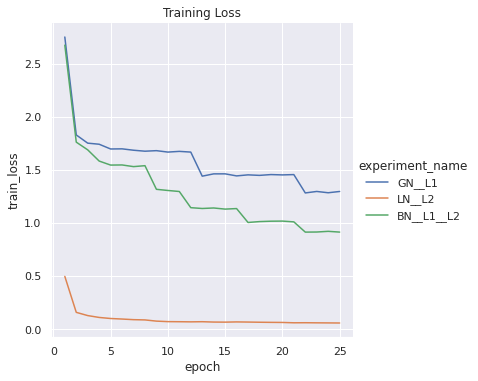

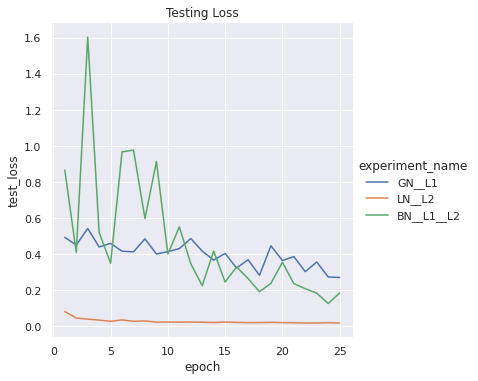

In [15]:
sns.relplot(data=exp_results_df, kind="line", x='epoch', y='train_loss', hue='experiment_name')
plt.title("Training Loss")
sns.relplot(data=exp_results_df, kind="line", x='epoch', y='test_loss', hue='experiment_name')
plt.title("Testing Loss")

Text(0.5, 1.0, 'Testing Accuracy')

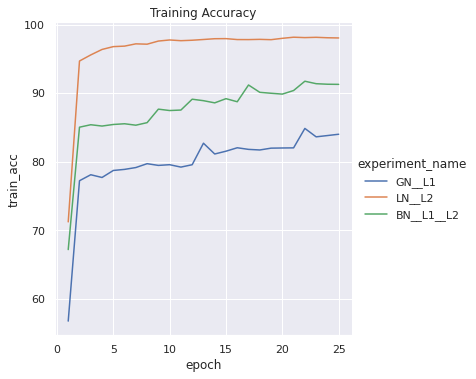

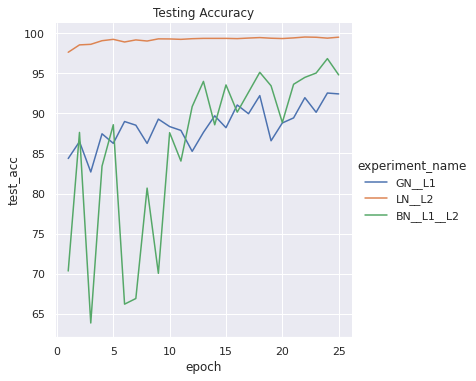

In [16]:
sns.relplot(data=exp_results_df, kind="line", x='epoch', y='train_acc', hue='experiment_name')
plt.title("Training Accuracy")
sns.relplot(data=exp_results_df, kind="line", x='epoch', y='test_acc', hue='experiment_name')
plt.title("Testing Accuracy")

In [59]:
import torch
import torchvision
%matplotlib inline

def get_wrong_predictions(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    wrong_correct = []
    wrong_predicted = []
    wrong_image_data = []

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            # test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            status = pred.eq(target.view_as(pred))
            # correct += status.sum().item()

            mistakes, _ = torch.where(status==False)
            if len(mistakes):
                m_data = data[mistakes]
                m_target = target[mistakes]
                m_output = output[mistakes]
                m_pred = pred[mistakes]
                correct = [x.item() for x in m_target.cpu().detach()]
                predicted = [x.item() for x in m_pred.cpu().detach()]
                image_data = [x for x in m_data.cpu().detach()]

                wrong_correct.extend(correct)
                wrong_predicted.extend(predicted)
                wrong_image_data.extend(image_data)
    
    return wrong_correct, wrong_predicted, wrong_image_data


def show_grid(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')


def show_wrong_images(targets, predicts, images, size=20, grid=(5, 4)):
    img_data_temp = []
    wps = []
    for n, (wc, wp, wi) in enumerate(zip(targets, predicts, images)):
        wps.append(wp)
        img_data_temp.append(wi)
        if n>18:
            break
    
    wrong_images_temp = torch.stack(img_data_temp)
    print()
    print(f"Mistakenly predicted as {wps}")

    grid_img = torchvision.utils.make_grid(wrong_images_temp, nrow=grid[0])
    show_grid(grid_img)

In [29]:
# Find 20 misclassified images for each of the 3 models, and show them as a 5x4 image matrix in 3 separately annotated images. 

GN__L1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Mistakenly predicted as [0, 5, 2, 9, 9, 1, 4, 4, 5, 1, 3, 1, 8, 5, 9, 1, 5, 9, 3, 8]


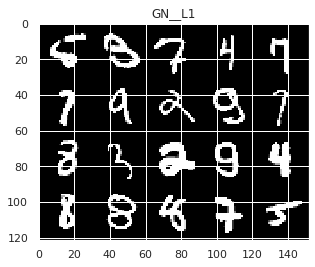

LN__L2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Mistakenly predicted as [0, 5, 2, 8, 3, 9, 9, 0, 5, 1, 2, 4, 5, 1, 7, 3, 3, 4, 3, 0]


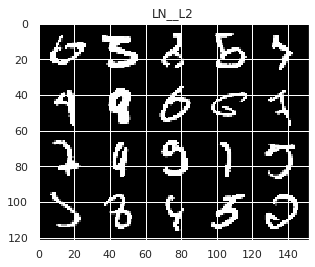

BN__L1__L2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Mistakenly predicted as [6, 4, 6, 4, 3, 0, 1, 4, 8, 6, 6, 4, 1, 4, 1, 7, 6, 4, 6, 4]


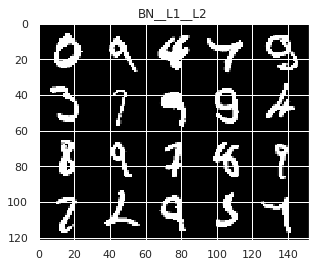

In [61]:
for experiment, model in models.items():
    print(experiment)
    targets, predicts, images = get_wrong_predictions(model, test_loader)
    show_wrong_images(targets, predicts, images)
    plt.title(experiment)
    plt.show()